In [1]:
from os.path import join as os_path_join

from scipy.io import loadmat, savemat
from numpy import zeros as np_zeros, ones as np_ones, zeros_like as np_zeros_like
from numpy import vectorize as np_vectorize
from numpy.linalg import norm
from numpy import spacing as np_spacing
from numpy import log10 as np_log10
from numpy import clip as np_clip, multiply as np_multiply
from matplotlib import pyplot as plt


from lib.better_envelope import better_envelope
# from lib.stft import stft
# from lib.non_iter_ls_inv_stft import non_iter_ls_inv_stft
target_dirname = '/Users/zhanwenchen/Documents/projects/beam_nn/DNNs/test/scan_batteries/target_phantom_anechoic_cyst_2p5mm/target_1/'

# # Test variables
# num_rows, num_elements, num_beams = 1624, 65, 128
# len_each_section = 16;
# frac_overlap = 0.9;
# padding = 16;
# # winInfo = {@rectwin};
# CHANDAT_FNAME = '/Users/zhanwenchen/Documents/projects/beam_nn/DNNs/test/scan_batteries/target_phantom_anechoic_cyst_2p5mm/target_1/chandat.mat'
# chandat = loadmat(CHANDAT_FNAME)['chandat']

# NEW_STFT_FNAME = '/Users/zhanwenchen/Documents/projects/beam_nn/DNNs/test/scan_batteries/target_phantom_anechoic_cyst_2p5mm/target_1/new_stft.mat'
# new_stft_f = loadmat(NEW_STFT_FNAME)
# new_stft_real = new_stft_f['new_stft_real']
# new_stft_imag = new_stft_f['new_stft_imag']


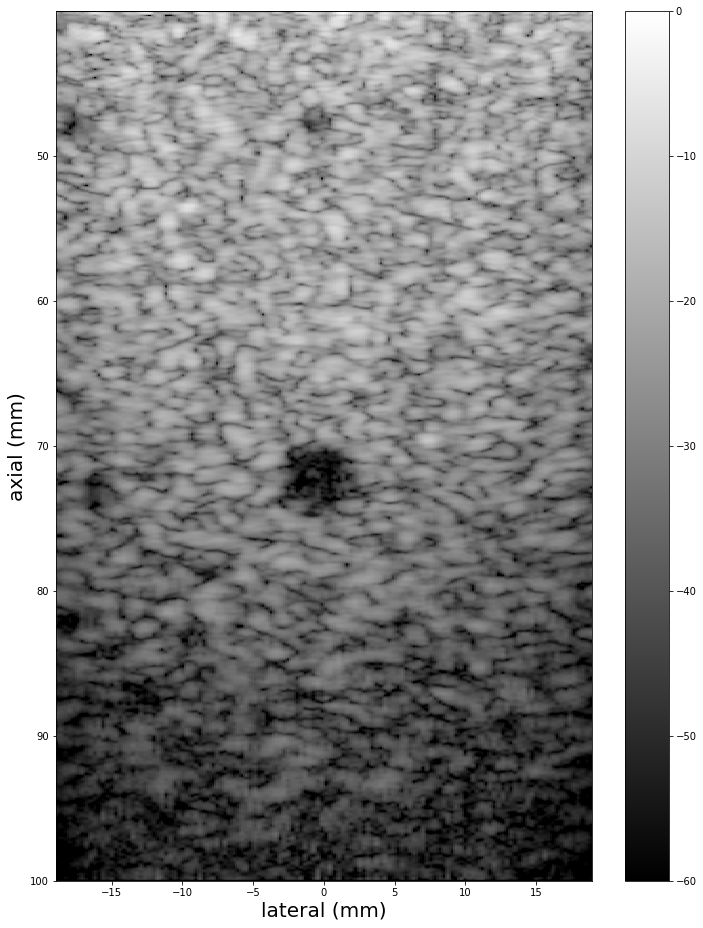

In [2]:
from lib.r6_dnn_image_display import r6_dnn_image_display

r6_dnn_image_display(target_dirname)

In [ ]:
DNN_IMAGE_FNAME = 'dnn_image.mat'
DNN_IMAGE_PATH = os_path_join(target_dirname, DNN_IMAGE_FNAME)
dnn_image_obj = loadmat(DNN_IMAGE_PATH)


In [ ]:
beam_position_x_up = dnn_image_obj['beam_position_x_up']
depth = dnn_image_obj['depth']
envUp_dB = dnn_image_obj['envUp_dB']
env_up = dnn_image_obj['envUp']


In [ ]:
from numpy import squeeze as np_squeeze

x = beam_position_x_up = np_squeeze(beam_position_x_up)
y = depth = np_squeeze(depth)

In [ ]:
fig = plt.figure(figsize=(12,16))
plt.imshow(envUp_dB, vmin=-60, vmax=0, cmap='gray', aspect='auto', extent = [beam_position_x_up[0]*1000,beam_position_x_up[-1]*1000,depth[-1]*1000, depth[0]*1000])
plt.colorbar()
FONT_SIZE = 20
plt.xlabel('lateral (mm)', fontsize=FONT_SIZE)
plt.ylabel('axial (mm)', fontsize=FONT_SIZE)

plt.show()

In [ ]:
def load_single_value(target_dirname, fname):
    path = os_path_join(target_dirname, fname)
    
    with open(path, 'r') as f:
        circle_radius = float(f.read())
        
    return circle_radius

In [ ]:
def get_circular_mask(xx, yy, circle_center, circle_radius):
    assert xx.shape == yy.shape
    circle_coords_x, circle_coords_y = circle_center
    return np_sqrt((xx-circle_coords_x) ** 2 + (yy-circle_coords_y) ** 2) <= circle_radius
    

In [ ]:
def get_rectangle_mask(xx, yy, xmin, xmax, ymin, ymax):
    return (xx >= xmin) & (xx <= xmax) & (yy >= ymin) & (yy <= ymax)
    

In [ ]:
CIRCLE_RADIUS_FNAME = 'circle_radius.txt'
CIRCLE_COORDS_X_FNAME = 'circle_xc.txt'
CIRCLE_COORDS_Y_FNAME = 'circle_zc.txt'
CIRCLE_RADIUS_PATH = os_path_join(target_dirname, CIRCLE_RADIUS_FNAME)

circle_radius = load_single_value(target_dirname, CIRCLE_RADIUS_FNAME)
circle_coords_x = load_single_value(target_dirname, CIRCLE_COORDS_X_FNAME)
circle_coords_y = load_single_value(target_dirname, CIRCLE_COORDS_Y_FNAME)


In [ ]:
from numpy import meshgrid as np_meshgrid

xx, yy = np_meshgrid(x, y)

In [ ]:
from numpy import sqrt as np_sqrt


mask_in = get_circular_mask(xx, yy, (circle_coords_x, circle_coords_y), circle_radius)


In [ ]:
# create rectangular region outside lesion
BOX_XMIN_RIGHT_FNAME = 'box_right_min.txt'
BOX_XMAX_RIGHT_FNAME = 'box_right_max.txt'
box_xmin_right = load_single_value(target_dirname, BOX_XMIN_RIGHT_FNAME)
box_xmax_right = load_single_value(target_dirname, BOX_XMAX_RIGHT_FNAME)

BOX_XMIN_LEFT_FNAME = 'box_left_min.txt'
BOX_XMAX_LEFT_FNAME = 'box_left_max.txt'
box_xmin_left = load_single_value(target_dirname, BOX_XMIN_LEFT_FNAME)
box_xmax_left = load_single_value(target_dirname, BOX_XMAX_LEFT_FNAME)

# Box shares y position and height with circle (diameter)
ymin = circle_coords_y - circle_radius;
ymax = circle_coords_y + circle_radius;
mask_out_left = (xx >= box_xmin_left) * (xx <= box_xmax_left) * (yy >= ymin) * (yy <= ymax)
mask_out_right = get_rectangle_mask(xx, yy, box_xmin_right, box_xmax_right, ymin, ymax)
mask_out = mask_out_left | mask_out_right


In [ ]:
# with_circle = envUp_dB.copy()
# with_circle[mask_out_left+mask_in+mask_out_right] = 0

# plt.figure(figsize=(12,16))
# plt.imshow(with_circle, vmin=-60, vmax=0, cmap='gray', aspect='auto', extent = [beam_position_x_up[0]*1000,beam_position_x_up[-1]*1000,depth[-1]*1000, depth[0]*1000])
# plt.colorbar()
# FONT_SIZE = 20
# plt.xlabel('lateral (mm)', fontsize=FONT_SIZE)
# plt.ylabel('axial (mm)', fontsize=FONT_SIZE)

# plt.show()

In [ ]:
env_up.shape

In [ ]:
env_up_inside_lesion = env_up[mask_in]

In [ ]:
mean_in = env_up_inside_lesion.mean()


In [ ]:
var_in = env_up_inside_lesion.var(ddof=1) # ddof is important cuz Matlab
print(var_in)

In [ ]:
env_up_outside_lesion = env_up[mask_out]

In [ ]:
mean_out = env_up_outside_lesion.mean()


In [ ]:
var_out = env_up_outside_lesion.var(ddof=1) # ddof is important cuz Matlab


In [ ]:
from math import log10 as math_log10, sqrt as math_sqrt

In [ ]:
CR = -20*math_log10(mean_in / mean_out)
CNR = 20*math_log10(abs(mean_in - mean_out)/math_sqrt(var_in + var_out))
SNR = mean_out / math_sqrt(var_out)


In [ ]:
CR

In [ ]:
CNR

In [ ]:
speckle_stats = [CR, CNR, SNR, mean_in, mean_out, var_in, var_out]


In [ ]:
speckle_stats_dict = {
    'CR': CR,
    'CNR': CNR,
    'SNR': SNR,
    'mean_inside_lesion': mean_in,
    'variance_inside_lesion': var_in,
    'mean_outside_lesion': mean_out,
    'variance_outside_lesion': var_out,
}

In [ ]:
from json import dump as json_dump

SPECKLE_STATS_FNAME = 'speckle_stats_dnn.txt'
SPECKLE_STATS_PATH = os_path_join(target_dirname, SPECKLE_STATS_FNAME)

with open(SPECKLE_STATS_PATH, 'w') as f:
    f.write("\n".join([str(item) for item in speckle_stats]))
    
SPECKLE_STATS_DICT_FNAME = 'speckle_stats_dnn.json'
SPECKLE_STATS_DICT_PATH = os_path_join(target_dirname, SPECKLE_STATS_DICT_FNAME)

with open(SPECKLE_STATS_DICT_PATH, 'w') as f:
    json_dump(speckle_stats_dict, f, indent=4)
    

In [ ]:
DNN_IMAGE_FNAME = 'dnn.png'
dnn_image_path = os_path_join(target_dirname, DNN_IMAGE_FNAME)
fig.savefig(dnn_image_path)